### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd


In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# from google.colab import files

# !cp /content/gdrive/MyDrive/ColabHannah/new_biota/pyfiles/carbon_levels.py /content
# !cp /content/gdrive/MyDrive/ColabHannah/new_biota/pyfiles/past.py /content
# !cp /content/gdrive/MyDrive/ColabHannah/new_biota/pyfiles/params.py /content
# !cp /content/gdrive/MyDrive/ColabHannah/new_biota/pyfiles/future.py /content

In [3]:
import os

wd = os.getcwd()
# print(wd)
os.chdir(wd +'/pyfiles/')
wd = os.getcwd()

print(wd)

C:\Users\rjmay\Code\GES\src\pyfiles


In [4]:
import carbon_levels
import past
import params
from future import scenario

In [5]:
# print(sys.path)

### Parameters  and conversion factors


In [6]:
ka, kd, delta_d, kH, AM, OM, M_upper, delta_a, K_1, K_2, Alk = params.ocean_params
mumix, mudeep, lambdaHat, gamma = params.temp_params
tao, beta,Cpf_moles, propCH4, propPassive, pf_init_T = params.permafrost_params
fds, fld, fls, flv, fnd, fns, fnv, frd, frs, fvd, fvs, beta_biota, q10, biota_init_T, npp_0 = params.biota_params

In [7]:
ppmtoMol = 1.77e+14 #mult by this for CO2 PPM -> Moles
molCO2toGT =  4.4e-14 #mult by this for moles CO2 -> GTC
ppmtoGT = 7.788 #mult by this for ppm to GTC
molCtoGT = 12/1e15

### Data



Getting the data in ppm for $CO_2$

In [8]:
file_loc = r"../../Data/WG1AR5_AIISM_Datafiles.xlsx"

# ppm_Data  = pd.read_excel(file_loc, 6, header = 7, index_col=0, usecols="A:D", skiprows=[8],skipfooter=40) #ppm
ppm_data_source  = pd.read_excel(file_loc, 6, header = 7, usecols="A:D", skiprows=[8],skipfooter=40) #ppm  NOte I didn't do an index col so I could get an array of years. 


ppm_data_source.columns = ['Year', 'CO2', 'CH4', 'N2O']

In [9]:
#linear interpolation

ppm_data = pd.DataFrame(columns=['Year', 'CO2', 'CH4', 'N2O'])

for k in ppm_data.columns:
    ppm_data[k] =  np.interp(np.arange(1750,2011), ppm_data_source.Year, ppm_data_source[k])

ppm_data = ppm_data.astype({'Year':'int'})




Getting the data in terms of ERF

In [10]:
# ERF_data  = pd.read_excel(file_loc, 8, header = 7, usecols="A:M", skipfooter=5) #ppm  NOte I didn't do an index col so I could get an array of years. 


 Carbon data

In [11]:

#global K_H K_1 K_2 delta_d delta_a AM Alk k_a k_d E_course
fname = r'../../Data/Global_Carbon_Budget_2021v1.0.xlsx'

carbon_df = pd.read_excel(fname, sheet_name = "Historical Budget", header = 16,
                                 names = ['Year', 'Fossil', 'LUC', 'Atm_Growth', 'Ocean_Sink', 'Land_Sink', 'Cement_Carb_Sink', 'Imbalance']);

#Dr Eikenberry's linear interp
#Do a linear interpolation from 0.2 to value at 1850 for LUC:
carbon_df.LUC.iloc[0:99] = np.interp(carbon_df.Year[0:99], [1751, 1849], [0.2, carbon_df.LUC[99]])

C:\Users\rjmay\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## Past Modeling

In [12]:
init_ppm = params.ppmCO2_1750 

initC = carbon_levels.get_C_init(init_ppm)
# new_QA = 1000 * ppmtoMol
# start_ocean = np.array([new_QA, 725 * ppmtoMol, 36262 * ppmtoMol])

print(initC * 12/ 1e15)

temp = np.array([0,0])

inits = np.concatenate((temp,initC), axis=None)

t_span=[1750,2010]
# ERF_data.head()


sol_2010, temp_track = past.solve_past(t_span, inits, ppm_data, carbon_df, True)



[  587.9232       725.39261348 36263.18537311   500.
    55.29411765  1808.82352941]


C:\Users\rjmay\Code\GES\src\pyfiles\past.py:95: RuntimeWarning: divide by zero encountered in log
  result = (npp_0 / molCtoGT) * (1 + beta_biota * ( np.log ( carbon /  params.ppmCO2_1750 )))


In [13]:
#state 2010
index_max = len(sol_2010.t) - 1
state_2010 = sol_2010.y[:,index_max] #QA not right here!!!!!

ppm_2010 = ppm_data.loc[ppm_data["Year"] == 2010].values[0][1]

molesQA = ppm_2010 / 1e6 * AM
state_2010[2] = molesQA

state_2010 * 12 / 1e15


array([9.72918126e-15, 2.63879141e-15, 8.24913789e+02, 7.40347498e+02,
       3.63102800e+04, 5.36945253e+02, 5.97344166e+01, 1.76711319e+03])

In [14]:
[9.72918126e-15, 2.63879141e-15, 8.24913789e+02, 7.40347498e+02,
       3.63102800e+04, 5.36945253e+02, 5.97344166e+01, 1.76711319e+03]

[9.72918126e-15,
 2.63879141e-15,
 824.913789,
 740.347498,
 36310.28,
 536.945253,
 59.7344166,
 1767.11319]

#### Figures

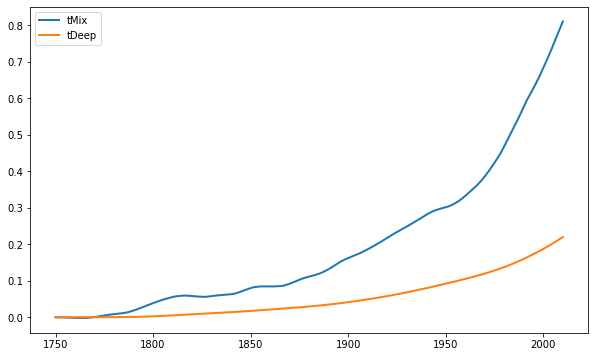

In [15]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,6))

ax1.plot(sol_2010.t, sol_2010.y[0,:], linewidth=2, label='tMix')
ax1.plot(sol_2010.t, sol_2010.y[1,:], linewidth=2, label='tDeep')
ax1.legend()


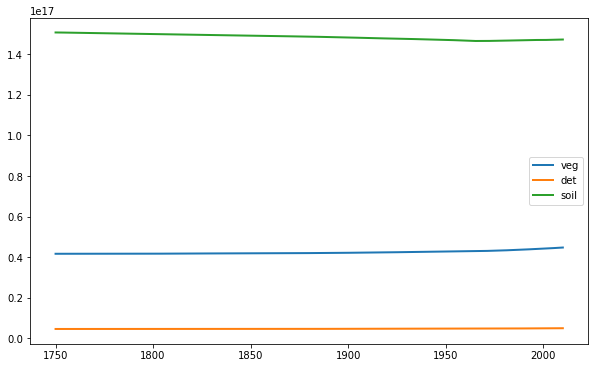

In [16]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,6))

ax1.plot(sol_2010.t, sol_2010.y[5,:], linewidth=2, label='veg')
ax1.plot(sol_2010.t, sol_2010.y[6,:], linewidth=2, label='det')
ax1.plot(sol_2010.t, sol_2010.y[7,:], linewidth=2, label='soil')

ax1.legend()

## Future data emissions
Starting to use emissions for future data analysis

#### Data and Methane Scenarios
Future RCP scenarios 

2.6, 4.5, 6, 8.5

In [17]:
choice = "45"

file_loc = r"../../Data/emissions/RCP"+choice+"_emissions.csv"

RCP_emit_df = pd.read_csv(file_loc, header = 3, usecols=[0,1,2,3,4,5], names = ["Year", "Fossil", "LUC", "CH4", "N2O", "SOx"] )

### Future model

In [18]:
# https://www.eea.europa.eu/data-and-maps/daviz/atmospheric-concentration-of-carbon-dioxide-5'
#2010 levels
ppbM = 1798
ppbN = 323.7 

In [19]:
tspan = [2010, 2300]

# IC_PF = np.array([7.93713150e+16, 6.20641903e+15, 1.46108124e+14 ])#  cpf, Lc, Lm Init For PF
IC_PF = np.array([Cpf_moles, 0, 0 ])#  cpf, Lc, Lm Init For PF

state = np.concatenate((state_2010, [ppbM, ppbN], IC_PF), axis = None)


In [20]:
state

array([8.10765105e-01, 2.19899284e-01, 6.87428157e+16, 6.16956248e+16,
       3.02585667e+18, 4.47454378e+16, 4.97786805e+15, 1.47259432e+17,
       1.79800000e+03, 3.23700000e+02, 8.62500000e+16, 0.00000000e+00,
       0.00000000e+00])

In [21]:
# tspan, state, RCP, custom_ch4(False), reduction of methane factor = .9, baseline=  140
# custom = True
# reduction = .95
# test = scenario(tspan, state, np.copy(temp_track), RCP_emit_df.copy(deep=True))


In [22]:
# test.get_scenarioPF()

# x = test.getEmitPF()
# print(x[2010:2050])

# plt.plot(x[2010:2100,1] * molCtoGT )
# plt.plot(x[2010:2300,1] * 16 / 1e12)

In [23]:
obj = scenario(tspan, state, np.copy(temp_track), RCP_emit_df.copy(deep=True))
obj1 = scenario(tspan, state, np.copy(temp_track), RCP_emit_df.copy(deep=True), True, .99, 266)
obj2 = scenario(tspan, state, np.copy(temp_track), RCP_emit_df.copy(deep=True), True, .9, 266)


In [24]:
sol = obj.get_scenario()
sol1 = obj1.get_scenario()
sol2 = obj2.get_scenario()

# print(obj.getFinalTemp(), obj1.getFinalTemp(), obj2.getFinalTemp())

# print(obj1.get_temp_track()[2007:2015])
RF  = obj2.getRadiativeForcing()[2010:2050]

# print(obj.get_temp_track()[2050], obj1.get_temp_track()[2050], obj2.get_temp_track()[2050])


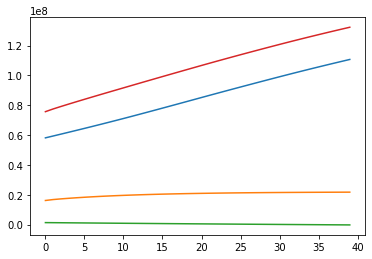

In [25]:
plt.plot(RF[:,0])
plt.plot(RF[:,1])
plt.plot(RF[:,2])
# plt.plot(RF[:,3])
plt.plot(RF[:,4])

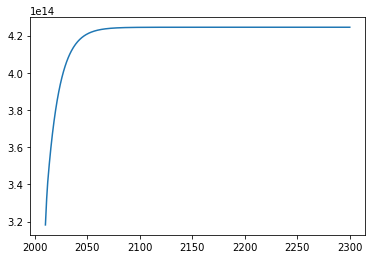

In [26]:

plt.plot(sol2.t, sol2.y[8,:])

In [27]:
solpf = obj.get_scenarioPF()
sol1pf = obj1.get_scenarioPF()
sol2pf = obj2.get_scenarioPF()

print(obj.getFinalTemp(), obj1.getFinalTemp(), obj2.getFinalTemp())

# print(obj.get_temp_track()[2050], obj1.get_temp_track()[2050], obj2.get_temp_track()[2050])

3.8990362785765447 3.8902778884200546 3.8887408827396253


In [28]:
# obj2.get_RCP()

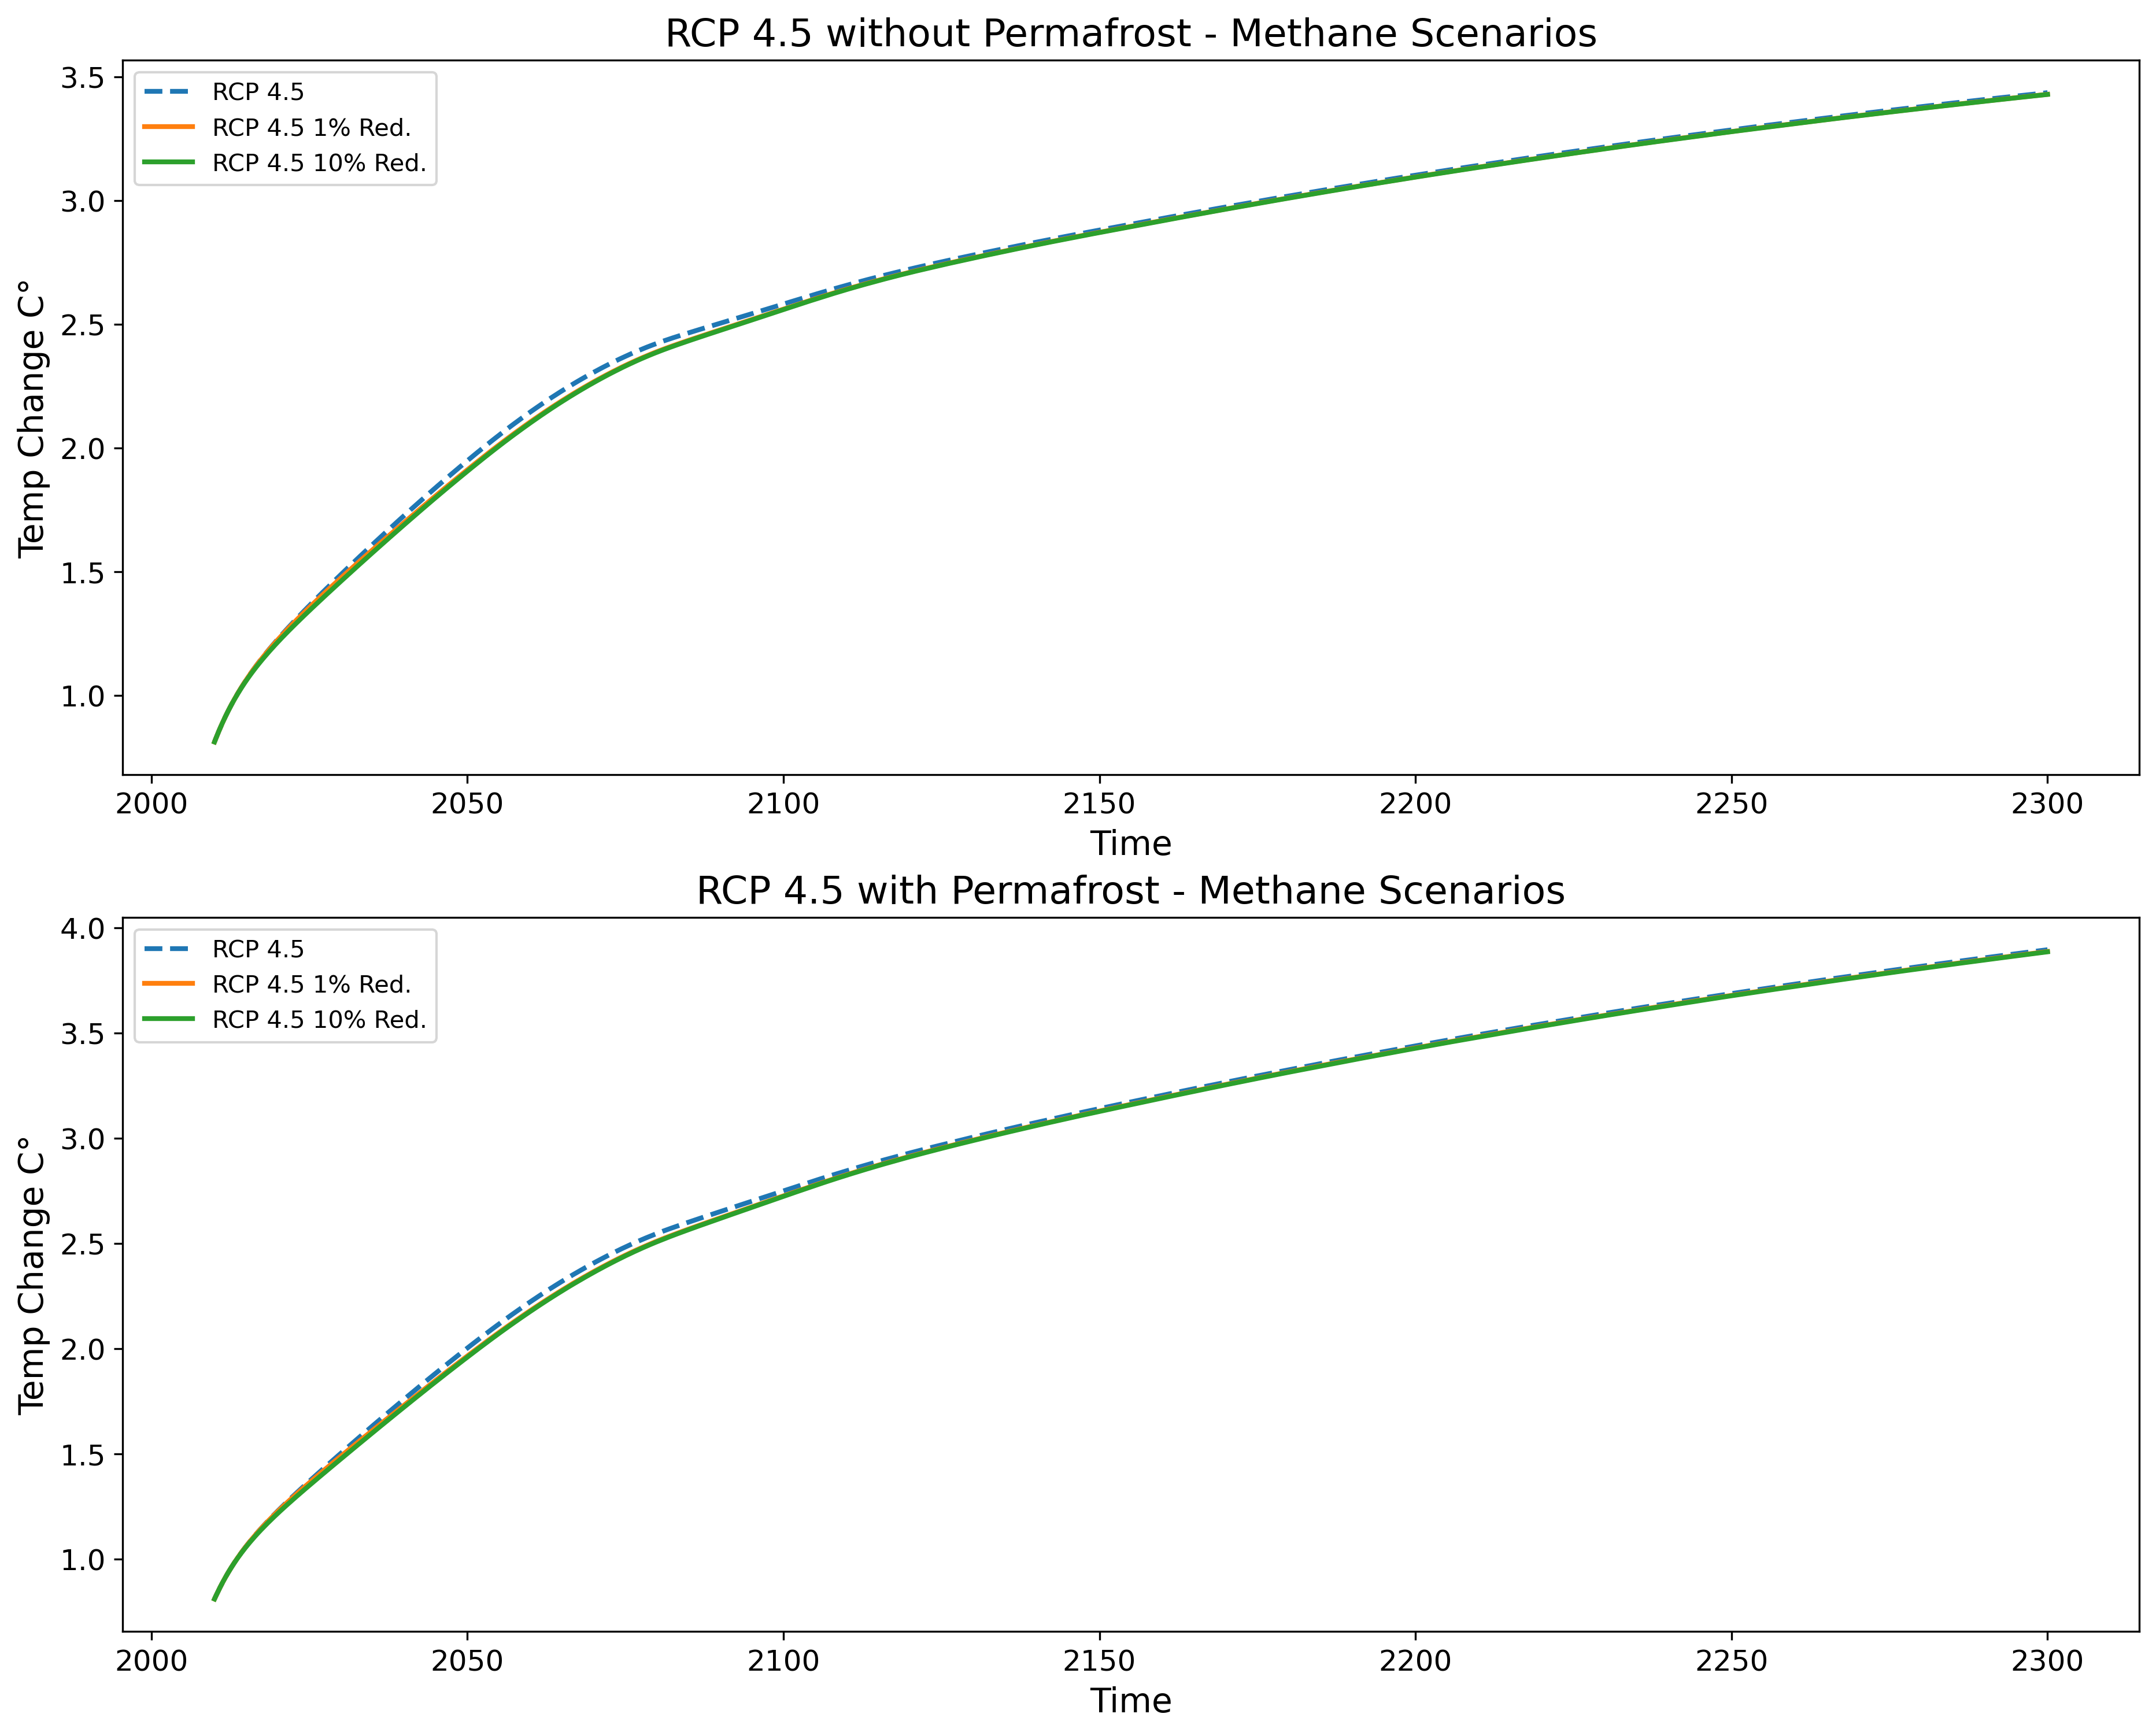

In [29]:
scen = "4.5"

fig, ax1 = plt.subplots(2, 1, figsize=(15,12),dpi =300)
fs = 14
ax1[0].plot(sol.t, sol.y[0,:],linewidth=2, label = "RCP " + scen, linestyle = "dashed")
ax1[0].plot(sol1.t, sol1.y[0,:], linewidth=2, label = "RCP "+ scen +" 1% Red.")
ax1[0].plot(sol2.t, sol2.y[0,:], linewidth=2, label = "RCP "+ scen + " 10% Red.")
ax1[0].set_xlabel("Time", fontsize = fs)
ax1[0].set_ylabel("Temp Change C°", fontsize = fs)
ax1[0].set_title("RCP "+ scen + " without Permafrost - Methane Scenarios", fontsize = fs +2)
ax1[0].tick_params(axis='both', labelsize=fs-2)
ax1[0].legend()


ax1[1].plot(solpf.t, solpf.y[0,:],linewidth=2, label = "RCP "+  scen, linestyle = "dashed")
ax1[1].plot(sol1pf.t, sol1pf.y[0,:],linewidth=2,  label = "RCP "+ scen +" 1% Red.")
ax1[1].plot(sol2pf.t, sol2pf.y[0,:], linewidth=2, label = "RCP "+ scen + " 10% Red.")
ax1[1].set_xlabel("Time", fontsize = fs)
ax1[1].set_ylabel("Temp Change C°", fontsize = fs)
ax1[1].set_title("RCP " + scen + " with Permafrost - Methane Scenarios", fontsize = fs+2)
ax1[1].tick_params(axis='both', labelsize=fs -2)
ax1[1].legend()

fname = 'RCP' +scen + 'scenario.png'
plt.savefig(fname, dpi=300, facecolor="white", bbox_inches='tight', pad_inches=0.05)
# files.download(fname)

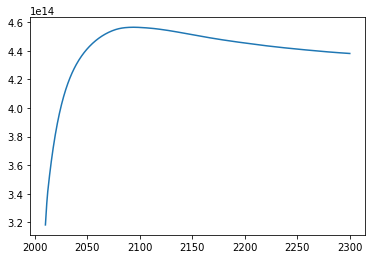

In [30]:
plt.plot(sol2pf.t, sol2pf.y[8,])

In [31]:
print(obj.get_temp_track()[2300])
print(obj1.get_temp_track()[2300])
print(obj2.get_temp_track()[2300])

3.8990362785765447
3.8902778884200546
3.8887408827396253
